<a href="https://colab.research.google.com/github/silprosa/fynesse_mlfc/blob/main/_notebooks/03-dataset-joining-practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 3: Dataset Joining and Access-Assess-Address Framework

### Radzim Sendyka

### [Neil D. Lawrence](http://inverseprobability.com), University of

Cambridge

### 2025-09-08

**Abstract**: In this lab session we will explore dataset joining
techniques, implement the Access-Assess-Address framework in practice,
work with the DSAIL Porini camera trap data, and build predictive models
for animal sightings.

$$
$$

<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!---->
<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!-- The last names to be defined. Should be defined entirely in terms of macros from above-->
<!--

-->

## Code Reuse with Fynesse

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_data-science/includes/osm-code-reuse-fynesse.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_data-science/includes/osm-code-reuse-fynesse.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

{We will be reusing some of the functions we created in the first
practical. This demonstrates one of the key principles of data science:
building reusable code libraries that can be applied across multiple
projects.

In [150]:
%%capture
%pip install osmnx

### Exercise 1

Install your Fyness library, and run code to show its available.

In [151]:
# Write your answer to Exercise 1 here


import shutil
shutil.rmtree("/content/fynesse_mlfc", ignore_errors=True)
!git clone https://github.com/silprosa/fynesse_mlfc.git
import os, subprocess, importlib, sys
sys.path.append("/content/fynesse_mlfc")
import fynesse



Cloning into 'fynesse_mlfc'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 404 (delta 16), reused 6 (delta 6), pack-reused 374 (from 3)
Receiving objects: 100% (404/404), 2.60 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (213/213), done.


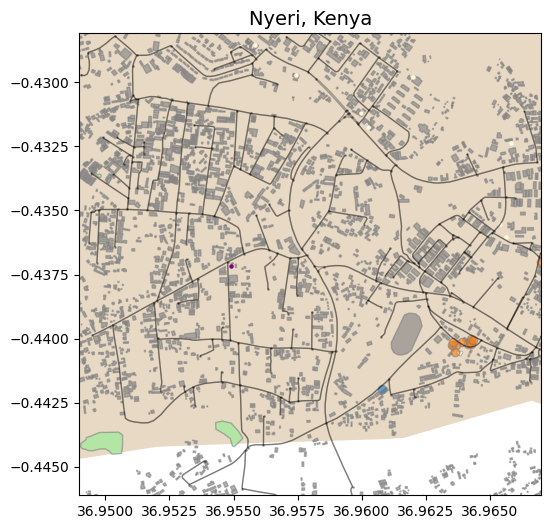

In [152]:
# Example: Plot a city map using your reusable function
fynesse.assess.plot_city_map('Nyeri, Kenya', -0.4371, 36.9580, 2)

## DSAIL-Porini Dataset

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_datasets/includes/dsail-porini-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_datasets/includes/dsail-porini-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

Head over to https://data.mendeley.com/datasets/6mhrhn7rxc/6 to explore
the DSAIL-Porini dataset. This dataset contains camera trap images and
annotations from Kenya, providing rich information about wildlife
patterns and behavior.

Locate the `camera_trap_dataset_annotation.xlsx` file and make it
available in this notebook.

In [153]:
import os
import requests
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

In [154]:
def download_if_not_exists(url, filepath):
    """Download file if it doesn't exist locally"""
    if os.path.exists(filepath):
        print(f"File already exists: {filepath}")
    else:
        print(f"Downloading: {url}")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(filepath, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded to: {filepath}")
    return filepath

In [155]:
# Download the DSAIL-Porini dataset
porini_file = download_if_not_exists(
    'https://data.mendeley.com/public-files/datasets/6mhrhn7rxc/files/641e83c9-16a3-485c-b247-b5701f8a5540/file_downloaded',
    'camera_trap_dataset_annotation.xlsx'
)

File already exists: camera_trap_dataset_annotation.xlsx


In [156]:
porini_df = pd.read_excel(porini_file)
porini_df.head()

Filename          Device Species Count  \
0  2021-08-01-07-31-10.jpg  Raspberry Pi 2  IMPALA     4   
1  2021-08-01-07-31-13.jpg  Raspberry Pi 2  IMPALA     2   
2  2021-08-01-07-31-35.jpg  Raspberry Pi 2  IMPALA     2   
3  2021-08-01-07-31-41.jpg  Raspberry Pi 2  IMPALA     2   
4  2021-08-01-07-31-45.jpg  Raspberry Pi 2  IMPALA     1   

                         Sex  Latitude  Longitude  
0  MALE,FEMALE,FEMALE,FEMALE -0.390386  36.962348  
1                MALE,FEMALE -0.390386  36.962348  
2                     FEMALE -0.390386  36.962348  
3                     FEMALE -0.390386  36.962348  
4                     FEMALE -0.390386  36.962348

## Joining Datasets

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_data-science/includes/dsail-porini-data-joining.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_data-science/includes/dsail-porini-data-joining.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

### Exercise 2

Geospatial data is particularly useful because it is the most common
index in the world, over which so many datasets can be joined. Find the
coordinate information in the dataset, and plot it on top of an OSM map.

You may want to deduplicate the coordinates before you plot!

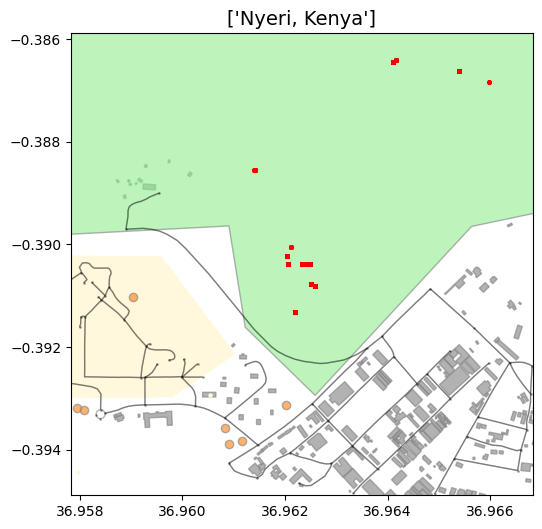

In [157]:
# Write your answer to Exercise 2 here

df_copy = porini_df.copy()


row = df_copy.iloc[73]
place_name = ['Nyeri, Kenya']
box_size_km = 1
latitude = float(row["Latitude"])
longitude = float(row["Longitude"])



# Convert km to degrees (approx 1° = 111km)
box_width = box_size_km / 111
box_height = box_size_km / 111

# Create bounding box
north = latitude + box_height/2
south = latitude - box_height/2
west = longitude - box_width/2
east = longitude + box_width/2
bbox = (west, south, east, north)




graph  = ox.graph_from_bbox(bbox)
area  = ox.geocode_to_gdf(place_name)
nodes, edges =ox.graph_to_gdfs(graph)
buildings = ox.features_from_bbox(bbox, tags={"building": True})
amenities = ox.features_from_bbox(bbox, tags={"amenity": True})
natural = ox.features_from_bbox(bbox, tags={"natural": True})



fig, ax = plt.subplots(figsize=(6,6))
area.plot(ax=ax, color="tan", alpha=0.5)
if not buildings.empty:
    buildings.plot(ax=ax, facecolor="gray", edgecolor="gray", alpha=0.6)
if not amenities.empty:
    amenities.plot(ax=ax, color="cornsilk", markersize=5)
if not natural.empty:
    natural.plot(ax=ax,facecolor="lightgreen", edgecolor="gray", alpha=0.6)
edges.plot(ax=ax, linewidth=1, edgecolor="black", alpha=0.3)
nodes.plot(ax=ax, color="black", markersize=1, alpha=0.3)

plt.scatter(df_copy["Longitude"], df_copy["Latitude"], color="red", s=5)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.set_title(place_name, fontsize=14)
plt.show()




<!-- Dsail Porini Address -->

## Sighting Predictions

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_data-science/includes/dsail-porini-data-preprocessing.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_data-science/includes/dsail-porini-data-preprocessing.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

We will use the dataset to create a simple prediction model for the
likelihood of animal sightings.

Let’s follow a minimal example of the Access-Assess-Address framework!

Reminder about Neil’s article on the framework
[here](https://inverseprobability.com/talks/notes/access-assess-address-a-pipeline-for-automated-data-science.html).

### Access

Access is already done, partly years ago by the DSAIL team, and two
cells above by us. Example tasks within access would be:

-   Setting up the cameras in the woods (done)
-   Collecting the pictures (done)
-   Labeling the dataset (done)
-   Making the excel file online accessible (done)
-   Downloading the file (done just now)}

In [158]:
porini_df.head()

Filename          Device Species Count  \
0  2021-08-01-07-31-10.jpg  Raspberry Pi 2  IMPALA     4   
1  2021-08-01-07-31-13.jpg  Raspberry Pi 2  IMPALA     2   
2  2021-08-01-07-31-35.jpg  Raspberry Pi 2  IMPALA     2   
3  2021-08-01-07-31-41.jpg  Raspberry Pi 2  IMPALA     2   
4  2021-08-01-07-31-45.jpg  Raspberry Pi 2  IMPALA     1   

                         Sex  Latitude  Longitude  
0  MALE,FEMALE,FEMALE,FEMALE -0.390386  36.962348  
1                MALE,FEMALE -0.390386  36.962348  
2                     FEMALE -0.390386  36.962348  
3                     FEMALE -0.390386  36.962348  
4                     FEMALE -0.390386  36.962348

### Assess

Have a look at the dataset for any issues that could stop us from being
able to cleanly analyse it.

Some issues:

-   Timestamps not readilly available. Hidden in image filenames.
-   No timestamps available for one of the cameras.
-   No Camera ID, but can be deduced from coordinates.

Decide how it would be best to address these and potentially other
issues with the data.

We would like an output dataframe that has a column for counts each
animal was spotted by each camera, and rows for each day in the
available range. You might want to use this opportunity to practice
[Pandas
MultiIndex](https://pandas.pydata.org/docs/user_guide/advanced.html).

In [159]:
import pandas as pd
import numpy as np
import re

In [160]:
# Copy original
df = porini_df.copy()

# Normalize species and parse counts
df["Species"] = df["Species"].astype(str).str.strip()

# Extract timestamp from filename
pat = re.compile(r"(\d{4})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})")
def parse_ts(name):
    m = pat.search(str(name))
    if not m:
        return pd.NaT
    y, M, d, h, m_, s = map(int, m.groups())
    return pd.Timestamp(y, M, d, h, m_, s)

df["timestamp"] = df["Filename"].map(parse_ts)
df["date"] = df["timestamp"].dt.date

# Camera ID from rounded lat/lon
df["Latitude"] = df["Latitude"].round(4)
df["Longitude"] = df["Longitude"].round(4)
coord_key = df["Latitude"].astype(str) + "," + df["Longitude"].astype(str)
codes, _ = pd.factorize(coord_key)
df["camera_id"] = pd.Series(codes).map(lambda i: f"C{int(i)+1:03d}")

# Extract camera coordinates dictionary (rounded)
camera_coords = (
    df.drop_duplicates(subset="camera_id")[["camera_id", "Latitude", "Longitude"]]
      .set_index("camera_id")
      .sort_index()
      .apply(tuple, axis=1)
      .to_dict()
)

# Group and count: number of pictures per species per camera per day
daily = (
    df.dropna(subset=["date"])
      .groupby(["date", "camera_id", "Species"])
      .size()
      .reset_index(name="photo_count")
      .pivot_table(index="date", columns=["camera_id", "Species"], values="photo_count", aggfunc="sum")
      .fillna(0)
      .astype(int)
      .sort_index()
)

# Fill missing dates
if not daily.empty:
    full_idx = pd.date_range(start=daily.index.min(), end=daily.index.max(), freq="D").date
    daily = daily.reindex(full_idx).fillna(0).astype(int)
    daily.index.name = "date"

print(camera_coords)
daily.tail()

{'C001': (-0.3904, 36.9623), 'C002': (-0.3886, 36.9614), 'C003': (-0.3866, 36.9654), 'C004': (-0.3864, 36.9642), 'C005': (-0.3908, 36.9625), 'C006': (-0.3913, 36.9622), 'C007': (-0.3904, 36.9621), 'C008': (-0.3904, 36.9624), 'C009': (-0.39, 36.9621), 'C010': (-0.3902, 36.962), 'C011': (-0.3868, 36.966), 'C012': (-0.3904, 36.9625), 'C013': (-0.3908, 36.9626), 'C014': (-0.3864, 36.9641)}


camera_id      C001                                                       \
Species    BUSHBUCK IMPALA IMPALA, MONKEY MONKEY WARTHOG WATERBUCK ZEBRA   
date                                                                       
2021-12-22        0      0              0      0       0         0     0   
2021-12-23        0      0              0      0       0         0     0   
2021-12-24        0      0              0      0       0         0     0   
2021-12-25        0      0              0      0       0         0     0   
2021-12-26        0      0              0      0       0         0     0   

camera_id      C002                    ...     C011   C012                  \
Species    BUSHBUCK CAN'T TELL IMPALA  ... BUSHBUCK IMPALA IMPALA, WARTHOG   
date                                   ...                                   
2021-12-22        0          0      0  ...        0      0               0   
2021-12-23        0          0      0  ...        0      0               0   
2021-12-24        0          0      0  ...        0      0               0   
2021-12-25        0          0      0  ...        0      0               0   
2021-12-26        0          0      0  ...        0      0               0   

camera_id        C013                                              C014  \
Species    CAN'T TELL IMPALA IMPALA, ZEBRA ZEBRA ZEBRA, IMPALA BUSHBUCK   
date                                                                      
2021-12-22          0      0             0     0             0        0   
2021-12-23          0    747           150    40            20      245   
2021-12-24        129   1577             0     0             0        0   
2021-12-25          0     22             0     0             0        0   
2021-12-26          0      5             0     0             0        0   

camera_id             
Species    WATERBUCK  
date                  
2021-12-22         0  
2021-12-23       330  
2021-12-24         0  
2021-12-25         0  
2021-12-26         0  

[5 rows x 54 columns]

Huh, looks like we have some more issues.

-   “Impala, Monkey” is not a species - should be counted towards two!
-   “Can’t Tell” shouldn’t be a species at all.
-   Some columns don’t exist (eg. `C011` has no `ZEBRA`). Let’s just
    fill them with zeros.

Additionally, there probably weren’t `1577` impalas spotted on Christmas
Eve 2021. This is a result of burst shots repetitively capturing the
same animal. For now, let’s just treat the data as binary, whether at
least one photo was taken on that day.

### Exercise 3

Use the cell below to implement the changes discussed above, and
potentially additional issues.

In [161]:
# Write your answer to Exercise 3 here


# Step 1: Flatten the multi-index and reshape the dataframe
daily_bin = daily.copy()
daily_bin.columns = pd.MultiIndex.from_tuples(daily_bin.columns)
# Step 2: Create a new clean dataframe
binary_rows = []
for (cam, species_str), series in daily_bin.items():
    # Split species (e.g. "IMPALA, MONKEY") into list
    species_list = [s.strip() for s in species_str.split(",")]
    for species in species_list:
        if species == "CAN'T TELL":
          continue
        col = series.copy()
        binary_rows.append((cam, species, (col > 0).astype(int)))
# Step 3: Rebuild dataframe
binary_df = pd.DataFrame({
    (cam, species): values
    for cam, species, values in binary_rows
}, index=daily_bin.index)
# Step 4: Sort columns and reformat
binary_df.columns = pd.MultiIndex.from_tuples(binary_df.columns)
binary_df = binary_df.sort_index(axis=1, level=[0, 1])
# Step 5: Ensure all possible (camera, species) pairs exist
# Get all unique cameras and species used across all rows
all_cameras = sorted(set(cam for cam, _ in binary_df.columns))
all_species = sorted(set(species for _, species in binary_df.columns))
# Build full column MultiIndex
full_columns = pd.MultiIndex.from_product([all_cameras, all_species], names=["camera_id", "Species"])
# Reindex to include all possible combinations, fill missing with 0
binary_df = binary_df.reindex(columns=full_columns, fill_value=0)
binary_df.tail()


camera_id      C001                                           C002         \
Species    BUSHBUCK IMPALA MONKEY WARTHOG WATERBUCK ZEBRA BUSHBUCK IMPALA   
date                                                                        
2021-12-22        0      0      0       0         0     0        0      0   
2021-12-23        0      0      0       0         0     0        0      0   
2021-12-24        0      0      0       0         0     0        0      0   
2021-12-25        0      0      0       0         0     0        0      0   
2021-12-26        0      0      0       0         0     0        0      0   

camera_id                  ...   C013                             C014         \
Species    MONKEY WARTHOG  ... MONKEY WARTHOG WATERBUCK ZEBRA BUSHBUCK IMPALA   
date                       ...                                                  
2021-12-22      0       0  ...      0       0         0     0        0      0   
2021-12-23      0       0  ...      0       0         0     1        1      0   
2021-12-24      0       0  ...      0       0         0     0        0      0   
2021-12-25      0       0  ...      0       0         0     0        0      0   
2021-12-26      0       0  ...      0       0         0     0        0      0   

camera_id                                  
Species    MONKEY WARTHOG WATERBUCK ZEBRA  
date                                       
2021-12-22      0       0         0     0  
2021-12-23      0       0         1     0  
2021-12-24      0       0         0     0  
2021-12-25      0       0         0     0  
2021-12-26      0       0         0     0  

[5 rows x 84 columns]

## Statistical Analysis of Sighting Patterns

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_data-science/includes/dsail-porini-probability-analysis.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_data-science/includes/dsail-porini-probability-analysis.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

### Exercise 4

Now let’s create a simple prediction system for whether a specific
`camera` captured a `species` on a given `date`. Let’s use the whole
dataset, except for the prediction target date.

Before we jump into addressing the question, let’s further assess the
data. Calculate and plot average probabilities for dates, species, and
cameras. You may want to implement some smoothing over dates, or group
them into longer ranges.

In [162]:
import matplotlib.pyplot as plt



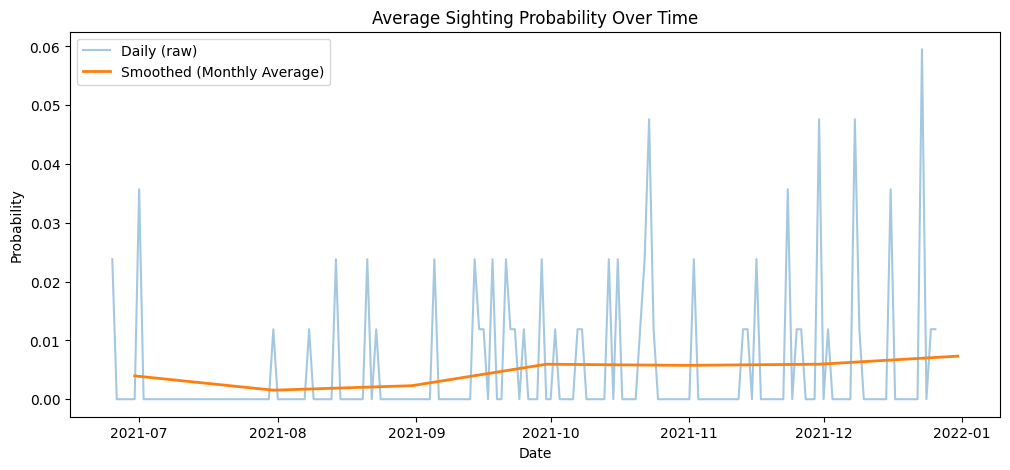

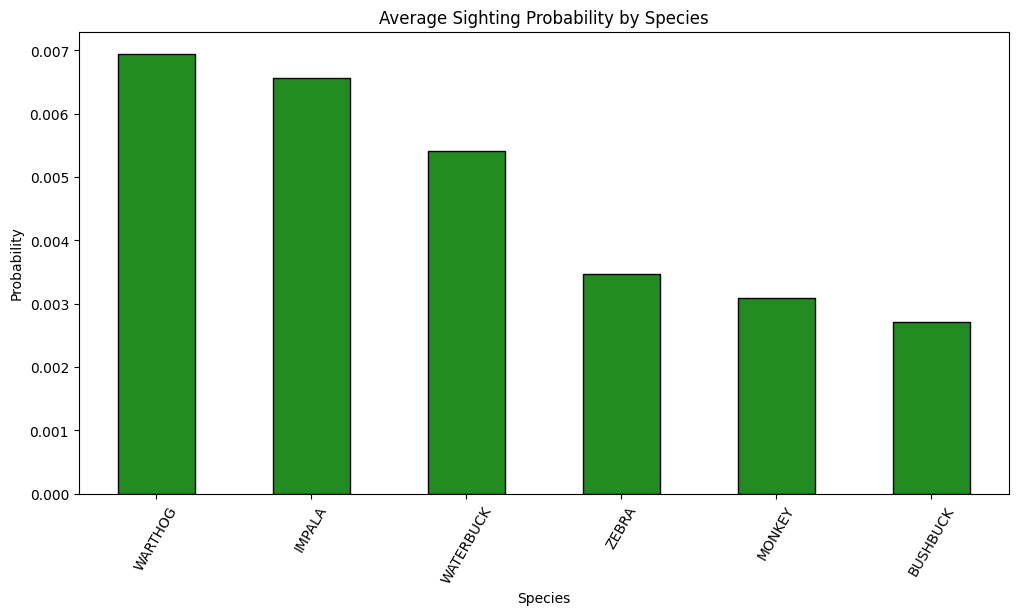

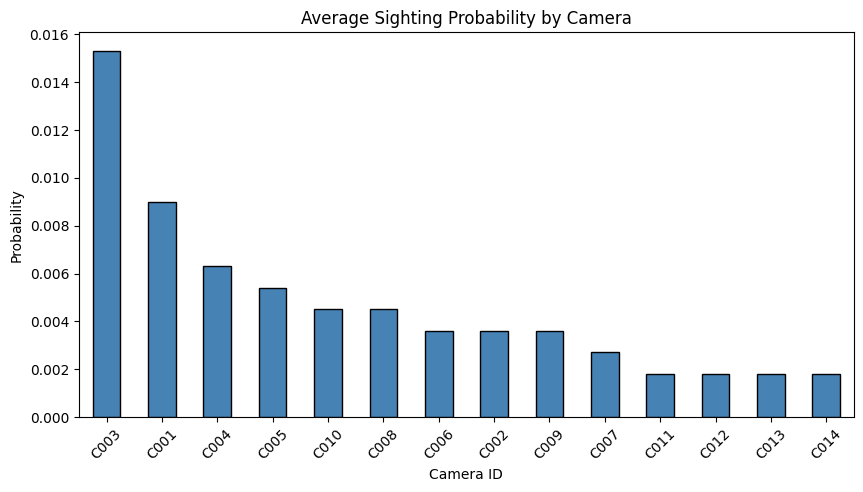

In [163]:
# Write your answer to Exercise 4 here


if not isinstance(binary_df.index, (pd.DatetimeIndex, pd.PeriodIndex, pd.TimedeltaIndex)):
    binary_df = binary_df.copy()
    binary_df.index = pd.to_datetime(binary_df.index, errors="coerce")
binary_df = binary_df.sort_index()

# raw daily mean across all (camera, species)

avg_by_date_raw = binary_df.mean(axis=1)



# set and apply smooth frequency
smooth_freq = "ME" # Monthly average, "YE" would be yearly
avg_by_date_smooth = avg_by_date_raw.resample(smooth_freq).mean()

# plot raw + smoothed
plt.figure(figsize=(12, 5))
plt.plot(avg_by_date_raw.index, avg_by_date_raw.values, alpha=0.4, label="Daily (raw)")
plt.plot(avg_by_date_smooth.index, avg_by_date_smooth.values, linewidth=2, label=f"Smoothed (Monthly Average)")
plt.title("Average Sighting Probability Over Time")
plt.xlabel("Date"); plt.ylabel("Probability"); plt.legend()
plt.show()

#Print these commands to help you understand what they do
#print(binary_df.index)
#print(binary_df.mean(axis=0))
#print(binary_df.mean(axis=0).groupby(level=1).mean())

#TODO Plot species and camera averages

avg_by_camera = binary_df.mean(axis=0).groupby(level=0).mean()
avg_by_camera.sort_values(ascending=False, inplace=True)


avg_by_species = binary_df.mean(axis=0).groupby(level=1).mean()
avg_by_species.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
avg_by_species.plot(kind="bar", color="forestgreen", edgecolor="black")
plt.title("Average Sighting Probability by Species")
plt.xlabel("Species")
plt.ylabel("Probability")
plt.xticks(rotation=60)
plt.show()

plt.figure(figsize=(10, 5))
avg_by_camera.plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Average Sighting Probability by Camera")
plt.xlabel("Camera ID")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.show()




Extension: which of these relationships that you found are statistically
significant?

In [164]:
# TODO


## Address: Naive Bayesian Prediction Model

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_ml/includes/dsail-porini-naive-bayes.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_ml/includes/dsail-porini-naive-bayes.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

Using the data we collected in the Access stage and understood in
Assess, we can now Address our question, and create a naive Bayesian
classification model for predicting the probability of a camera sighting
a species on a given day.

$$
P(1 \mid c, s, d) = \frac{P(1, c, s, d)}{P(c, s, d)}
$$

$$
\text{Using chain rule:} \quad P(1, c, s, d) = P(1) \cdot P(c, s, d \mid 1)
$$

$$
\text{Using conditional independence:} \quad P(c, s, d \mid 1) = P(c \mid 1) \cdot P(s \mid 1) \cdot P(d \mid 1)
$$

$$
P(1 \mid c, s, d) = \frac{P(1) \cdot P(c \mid 1) \cdot P(s \mid 1) \cdot P(d \mid 1)}{P(c,s,d)}
$$

$$
\text{Using Bayes' rule:} \quad  P(c \mid 1) = \frac{P(1 \mid c) \cdot P(c)}{P(1)} \quad \text{(and similarly for $s$ and $d$)}
$$

$$
\Rightarrow P(1 \mid c, s, d) = \frac{P(1) \cdot \frac{P(1 \mid c) \cdot P(c)}{P(1)} \cdot \frac{P(1 \mid s) \cdot P(s)}{P(1)} \cdot \frac{P(1 \mid d) \cdot P(d)}{P(1)}}{P(c,s,d)}
$$

$$
= \frac{P(1 \mid c) \cdot P(1 \mid s) \cdot P(1 \mid d) \cdot P(c) \cdot P(s) \cdot P(d)}{P(1)^2 \cdot P(c,s,d)}
$$

$$
\text{Assuming independence:}
$$

$$
P(1 \mid c,s,d)=\frac{P(1 \mid c) \cdot P(1 \mid s) \cdot P(1 \mid d)}{P(1)^2}
$$

$$
\begin{align*}
&c = \text{camera ID (e.g., C001)} \\
&s = \text{species (e.g., IMPALA)} \\
&d = \text{smoothed date (e.g., month, or Gaussian-filtered day)}
\end{align*}
$$

### Exercise 5

Implement the model below.

In [211]:
# Write your answer to Exercise 5 here


from typing import Union
import pandas as pd
import numpy as np
from datetime import date as DateType

def bayes_sighting_probability(df, camera, species, date) -> float:
    """
    Removes a specific observation and estimates the probability of sighting
    a given species at a given camera on a specific date.

    Parameters:
        df (pd.DataFrame): DataFrame with MultiIndex columns (camera, species) and datetime.date index.
        camera (str): Camera ID (e.g. 'C001').
        species (str): Species name (e.g. 'IMPALA').
        date (str or datetime.date or pd.Timestamp): Date of the observation.

    Returns:
        float: Estimated sighting probability - TODO.
    """
    if isinstance(date, str) or isinstance(date, pd.Timestamp):
        date = pd.to_datetime(date).date()

    df_blind = df.copy()
    df_blind.loc[date, (camera, species)] = None

    #TODO



    p1 = df_blind.stack(future_stack=True).mean().mean()
    p1_c = df_blind[camera].stack(future_stack=True).mean()
    p1_s = df_blind.xs(species, axis=1, level=1).stack(future_stack=True).mean()
    # Probability conditioned on date
    #avg_by_date_raw = df_blind.mean(axis=1)
    #avg_by_date_raw.index = pd.to_datetime(avg_by_date_raw.index)  # convert back for resample
    #avg_by_date_smooth = avg_by_date_raw.resample("ME").mean()
    # Align with date
    #p1_d = avg_by_date_smooth.loc[:pd.to_datetime(date)].iloc[-1]
    p1_d=  binary_df.mean(axis=1).mean()

    prob = (p1_c * p1_s * p1_d) / (p1 ** 2)

    return float(prob)

    raise NotImplementedError("Prediction logic not implemented yet.")




Well done! We should now have a working Access-Assess-Address data
science pipeline! Let’s see how it does.

In [196]:
binary_df.head(10)

camera_id      C001                                           C002         \
Species    BUSHBUCK IMPALA MONKEY WARTHOG WATERBUCK ZEBRA BUSHBUCK IMPALA   
date                                                                        
2021-06-25        0      0      0       0         0     0        0      1   
2021-06-26        0      0      0       0         0     0        0      0   
2021-06-27        0      0      0       0         0     0        0      0   
2021-06-28        0      0      0       0         0     0        0      0   
2021-06-29        0      0      0       0         0     0        0      0   
2021-06-30        0      0      0       0         0     0        0      0   
2021-07-01        0      0      0       1         1     1        0      0   
2021-07-02        0      0      0       0         0     0        0      0   
2021-07-03        0      0      0       0         0     0        0      0   
2021-07-04        0      0      0       0         0     0        0      0   

camera_id                  ...   C013                             C014         \
Species    MONKEY WARTHOG  ... MONKEY WARTHOG WATERBUCK ZEBRA BUSHBUCK IMPALA   
date                       ...                                                  
2021-06-25      0       1  ...      0       0         0     0        0      0   
2021-06-26      0       0  ...      0       0         0     0        0      0   
2021-06-27      0       0  ...      0       0         0     0        0      0   
2021-06-28      0       0  ...      0       0         0     0        0      0   
2021-06-29      0       0  ...      0       0         0     0        0      0   
2021-06-30      0       0  ...      0       0         0     0        0      0   
2021-07-01      0       0  ...      0       0         0     0        0      0   
2021-07-02      0       0  ...      0       0         0     0        0      0   
2021-07-03      0       0  ...      0       0         0     0        0      0   
2021-07-04      0       0  ...      0       0         0     0        0      0   

camera_id                                  
Species    MONKEY WARTHOG WATERBUCK ZEBRA  
date                                       
2021-06-25      0       0         0     0  
2021-06-26      0       0         0     0  
2021-06-27      0       0         0     0  
2021-06-28      0       0         0     0  
2021-06-29      0       0         0     0  
2021-06-30      0       0         0     0  
2021-07-01      0       0         0     0  
2021-07-02      0       0         0     0  
2021-07-03      0       0         0     0  
2021-07-04      0       0         0     0  

[10 rows x 84 columns]

In [205]:
prob = bayes_sighting_probability(binary_df, "C001", "IMPALA", "2021-7-30")
print(prob)

0.0106336398323638


### Evaluation

The data is extremely sparse, with less than 1% of values being `1`.
This is a challenge, as checking naive accuracy would make always-zero a
very very good predictor.

Let’s evaluate our prediction system using `log-loss`
i.e. `cross-entropy`:

$$
\mathcal{L} = - \frac{1}{N} \sum_{i=1}^{N}
\Big[
    y_i \, \log(\hat{p}_i) + (1 - y_i) \, \log(1 - \hat{p}_i)
\Big]
$$

### Exercise 6

Implement the loss function below.

In [212]:
# Write your answer to Exercise 6 here

def cross_entropy(y_true, y_pred):
    #TODO
    eps=1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)  # Avoid log(0) and log(1)
    y_true = np.array(y_true)

    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

    raise NotImplementedError("Cross entropy not implemented yet.")

def evaluate_prediction_system(df, cross_entropy, max_samples=1000):
    # Randomly sample up to 1000, if full evaluation taking too long
    np.random.seed(42)
    coords = [(date, camera, species) for date in df.index for (camera, species) in df.columns]
    if len(coords) > max_samples:
        coords = np.random.choice(len(coords), size=max_samples, replace=False)
        coords = [coords[i] if isinstance(coords[i], tuple) else
                  [(date, camera, species) for date in df.index for (camera, species) in df.columns][coords[i]]
                  for i in range(len(coords))]
    else:
        coords = coords

    y_true = []
    y_pred = []

    for date, camera, species in coords:
        value = df.loc[date, (camera, species)]
        y_true.append(value)
        prob = cross_entropy(df, camera, species, date)
        y_pred.append(prob)

    return cross_entropy(y_true, y_pred)

# Let's pass our function to be evaluated. This could take quite some time if your function is complex.
evaluate_prediction_system(binary_df, bayes_sighting_probability)



TypeError: bayes_sighting_probability() missing 2 required positional arguments: 'species' and 'date'

For reference, predicting a constant probability (eg. 0.5%) gives a loss
of around 0.026. This should be the benchmark number we want to improve
on. If your model does better than that, well done!

*Note: our approach included look-ahead bias - making predictions based
on data that we would not have access to at the time. For real-life
deployment, we would need to limit our training data to before
individual test cases.*

## Improving the Method: Correlated Variables

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_ml/includes/dsail-porini-correlation-analysis-improvements.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_ml/includes/dsail-porini-correlation-analysis-improvements.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

The model above was quite simplified, and it disregarded any
correlations between the three variables. Since cameras are close to
each other, maybe they are more likely to capture the same animals on
the same day? Maybe some animals like or avoid some areas, or some other
animals? If any of the above is true, we can’t really be using simple
Bayes’ rule classification.

### Exercise 7

Analyse the data again to find the strongest relationships which can be
used to improve predictions. Plot correlation matrices and other helpful
charts.

Have a short read through the [DSAIL-Porini
paper](https://www.sciencedirect.com/science/article/pii/S2352340922010666)
for inspiration about other probability analyses that can be done here.

In [ ]:
# Write your answer to Exercise 7 here






Extension: Use what you found to improve your prediction model, and
compare it against the previous one.

In [208]:
from typing import Union
import pandas as pd
import numpy as np
from datetime import date as DateType

def improved_sighting_probability(df, camera, species, date) -> float:
    """
    Removes a specific observation and estimates the probability of sighting
    a given species at a given camera on a specific date.

    Parameters:
        df (pd.DataFrame): DataFrame with MultiIndex columns (camera, species) and datetime.date index.
        camera (str): Camera ID (e.g. 'C001').
        species (str): Species name (e.g. 'IMPALA').
        date (str or datetime.date or pd.Timestamp): Date of the observation.

    Returns:
        float: Estimated sighting probability - TODO.
    """
    if isinstance(date, str) or isinstance(date, pd.Timestamp):
        date = pd.to_datetime(date).date()

    df_blind = df.copy()
    df_blind.loc[date, (camera, species)] = None

    #TODO

    raise NotImplementedError("Prediction logic not implemented yet.")

## Extended Exercises

We didn’t use all of the available data when we just classified days as
“sighting” or “no sighting.” Extend your analysis to include all the
information in the file, like numbers of sightings and numbers of
animals in the photos.

This will be quite challenging due to burst shots - assess the dataset
and come up with a good definition of what a burst is, and a data
structure that has the information you chose as important.

Example burst data: - Camera, Date, Species - Time Start, Time End -
Number of photos - Average/most animals in a photo

*Particular challenge around deduplicating multi-species sightings.*

### Exercise 8

Use this additional data and repeat the analysis you did above. Aim to
further improve predictions and write a new function like
`burst_sighting_probability('C001', 'IMPALA', '2021-12-24')`.

In [ ]:
# Write your answer to Exercise 8 here






### Exercise 9

Compare the results and note the improvement (or lack thereof) against
the two previous prediction functions you created.

In [ ]:
# Write your answer to Exercise 9 here






### Exercise 10

What other benefits does your new system provide? Can you modify it to
provide more predictions, like the expected number of sightings, the
number of animals?

In [ ]:
# Write your answer to Exercise 10 here






## Database Integration with SQLite

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_datasets/includes/dsail-porini-sqlite-database-creation.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_datasets/includes/dsail-porini-sqlite-database-creation.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

Throughout the course you will work with various datasets and data
formats. An SQL database is one of the most common ways to store large
amounts of data. We recognise that many of you may be familiar with this
already, but let’s use this example to build a small toy database of
animal sightings based on the excel file and the dataframes we created.

### Exercise 11

-   Create a local database (eg. `sqlite3`).
-   Add a table with animal sighting data.
-   Add a table with camera coordinates data.
-   Set indices on columns you might search by (eg. `CameraID`, `Date`).
    Make sure the index types make sense!
-   Look into multi column indices, and set one on `Latitude` and
    `Longitude`.
-   Demonstrate success with a couple SQL queries, eg. counting `IMPALA`
    sightings within a `200m` square around `-0.3866, 36.9649`.

Helpful links:

[SQL Intro, Creating Tables, Indices,
Joins](https://www.w3schools.com/sql/sql_intro.asp)

[Multi-Column
Indices](https://stackoverflow.com/questions/179085/multiple-indexes-vs-multi-column-indexes)

Remember to include reusable code from this and previous exercises in
your Fynesse library!

In [ ]:
# Write your answer to Exercise 11 here






## Extended Analysis: Burst Detection

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/snippets/edit/main/_ml/includes/dsail-porini-burst-detection-analysis.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/snippets/edit/main/_ml/includes/dsail-porini-burst-detection-analysis.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

We didn’t use all of the available data when we just classified days as
“sighting” or “no sighting.” Change your analysis to include the number
of sightings and the number of animals in the photos.

This will be quite challenging due to burst shots - assess the dataset
and come up with a good definition of what a burst is, and a data
structure that has the information you chose as important.

Example burst data: - Camera, Date, Species - Time Start, Time End -
Number of photos - Average/most animals in a photo

Particular hardship around deduplicating multi-species sightings.

### Exercise 12

Use this additional data and repeat the analysis you did above. Further
improve predictions and write a new function like
`burst_sighting_probability('C001', 'IMPALA', '2021-12-24')`.

In [ ]:
# Write your answer to Exercise 12 here






### Exercise 13

Compare the results and note the improvement (or lack thereof) against
the two previous prediction functions you created.

In [ ]:
# Write your answer to Exercise 13 here






### Exercise 14

What other benefits does your new system provide? Can you modify it to
provide more predictions, like the expected number of sightings, the
number of animals?

In [ ]:
# Write your answer to Exercise 14 here






End of Practical 3

     _______  __   __  _______  __    _  ___   _  _______  __
    |       ||  | |  ||   _   ||  |  | ||   | | ||       ||  |
    |_     _||  |_|  ||  |_|  ||   |_| ||   |_| ||  _____||  |
      |   |  |       ||       ||       ||      _|| |_____ |  |
      |   |  |       ||       ||  _    ||     |_ |_____  ||__|
      |   |  |   _   ||   _   || | |   ||    _  | _____| | __
      |___|  |__| |__||__| |__||_|  |__||___| |_||_______||__|

::: {.cell .markdown}

## References